## Загрузим нужные библиотеки

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline

В начале остановимся на наиболее перспективных навыках

In [113]:
df_train = pd.read_csv("./content/train_dataset_train.csv")

In [114]:
df_train.head()

,id,type
0,ОРГ1-02050,2
1,ОРГ1-02783,2
2,ОРГ2-06173,0
3,ОРГ2-05359,2
4,ОРГ1-00803,2


In [115]:
df_train['type'].value_counts()

2    298
0    153
1     74
3     25
Name: type, dtype: int64

In [7]:
# id = 'ОРГ1-02050'

In [8]:
df_test = pd.read_csv("./content/test_dataset_test.csv")

## Объединяем обучающий и тестовый набор вместе

In [9]:
df_train['Тип'] = 'train'
df_test['Тип'] = 'test'

In [10]:
df = pd.concat([df_train, df_test], axis=0)

In [11]:
df

,id,type,Тип
0,ОРГ1-02050,2,train
1,ОРГ1-02783,2,train
2,ОРГ2-06173,0,train
3,ОРГ2-05359,2,train
4,ОРГ1-00803,2,train
...,...,...,...
257,ОРГ1-02893,0,test
258,ОРГ2-01077,0,test
259,ОРГ1-00469,0,test
260,ОРГ1-02060,0,test


In [12]:
df['id'].value_counts()

ОРГ1-02050    1
ОРГ1-02587    1
ОРГ1-00467    1
ОРГ2-04913    1
ОРГ1-02890    1
             ..
ОРГ1-00665    1
ОРГ1-02781    1
ОРГ2-04135    1
ОРГ1-02076    1
ОРГ2-05042    1
Name: id, Length: 812, dtype: int64

## Анализируем звонки

In [13]:
df_calls = pd.read_csv("./content/Calls.csv")

In [14]:
df_calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 407867 entries, 0 to 407866
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Date               407867 non-null  object
 1   CallTime           407867 non-null  object
 2   NumberOfCalls      407867 non-null  int64 
 3   Вид учета времени  392655 non-null  object
 4   InOut              407867 non-null  object
 5   id                 407867 non-null  object
dtypes: int64(1), object(5)
memory usage: 18.7+ MB


In [15]:
df_calls[df_calls['id']=='ОРГ1-02050']

,Date,CallTime,NumberOfCalls,Вид учета времени,InOut,id
5400,"2021-01-29 00:00:00,000","0,00083333333333333328",1,Будни,ToUser,ОРГ1-02050
7828,"2021-03-10 00:00:00,000","0,00055555555555555556",1,Будни,ToUser,ОРГ1-02050
8526,"2021-01-29 00:00:00,000","0,0016666666666666666",1,Будни,ToUser,ОРГ1-02050
12841,"2021-09-27 00:00:00,000","0,0077777777777777776",1,Будни,ToUser,ОРГ1-02050
13460,"2021-03-12 00:00:00,000","0,0069444444444444441",1,Будни,ToUser,ОРГ1-02050
...,...,...,...,...,...,...
382592,"2021-03-26 00:00:00,000","0,029444444444444443",2,Будни,ToUser,ОРГ1-02050
391245,"2021-10-01 00:00:00,000","0,04777777777777778",2,Будни,ToUser,ОРГ1-02050
397430,"2021-12-13 00:00:00,000","0,030555555555555555",2,Будни,ToUser,ОРГ1-02050
399004,"2021-03-05 00:00:00,000","0,01",2,Будни,ToUser,ОРГ1-02050


In [16]:
df_calls['CallTime'] = df_calls['CallTime'].str.replace(',','.')
df_calls['CallTime'] = df_calls['CallTime'].astype(float)

In [17]:
df_calls['Date'].value_counts() # 364 дня

2021-11-23 00:00:00,000    2128
2021-12-23 00:00:00,000    2037
2021-10-27 00:00:00,000    2015
2021-11-25 00:00:00,000    2014
2021-12-21 00:00:00,000    2007
                           ... 
2021-08-01 00:00:00,000      11
2021-09-12 00:00:00,000       9
2021-09-05 00:00:00,000       5
2021-01-01 00:00:00,000       5
2021-07-18 00:00:00,000       4
Name: Date, Length: 364, dtype: int64

In [18]:
df_calls['Вид учета времени'].value_counts() # 384715 - будни 7940 - выходные дни

Будни           384715
Выходные дни      7940
Name: Вид учета времени, dtype: int64

In [19]:
df_calls['InOut'].value_counts()

ToUser      219896
FromUser    187971
Name: InOut, dtype: int64

На основании вышеприведенных данных, для каждого пользователя добавляем 4 характеристики: среднее кол-во звонков (исходящие, входящие), средняя длительность (входящих, исходящих)

In [20]:
df_calls_g = df_calls.groupby(['id', 'InOut']).agg({'NumberOfCalls':'mean', 'CallTime':'mean'})
df_calls_g = df_calls_g.reset_index()
df_calls_g

,id,InOut,NumberOfCalls,CallTime
0,ОРГ1-00004,FromUser,12.770909,0.306858
1,ОРГ1-00004,ToUser,8.117424,0.296248
2,ОРГ1-00005,FromUser,6.353474,0.379376
3,ОРГ1-00005,ToUser,2.551095,0.268580
4,ОРГ1-00028,FromUser,4.941176,0.123704
...,...,...,...,...
1992,ОРГ2-05629,FromUser,1.000000,0.766007
1993,ОРГ2-05862,FromUser,1.250000,0.078819
1994,ОРГ2-05932,FromUser,1.095238,0.284458
1995,ОРГ2-06006,FromUser,1.000000,0.220278


In [21]:
df_calls_g = pd.pivot_table(df_calls_g, index='id', columns='InOut', values=['NumberOfCalls','CallTime'], aggfunc=np.sum)
df_calls_g = df_calls_g.reset_index()

In [22]:
df_calls_g.columns= ['id','CallTimeIn', 'CallTimeOut', 'NumberOfCallsIn', 'NumberOfCallsOut']
df_calls_g

,id,CallTimeIn,CallTimeOut,NumberOfCallsIn,NumberOfCallsOut
0,ОРГ1-00004,0.306858,0.296248,12.770909,8.117424
1,ОРГ1-00005,0.379376,0.268580,6.353474,2.551095
2,ОРГ1-00028,0.123704,0.139695,4.941176,4.334677
3,ОРГ1-00030,0.136582,0.101014,6.128302,5.243346
4,ОРГ1-00044,0.214466,0.256929,6.442006,5.972810
...,...,...,...,...,...
1066,ОРГ2-05629,0.766007,NaN,1.000000,NaN
1067,ОРГ2-05862,0.078819,NaN,1.250000,NaN
1068,ОРГ2-05932,0.284458,NaN,1.095238,NaN
1069,ОРГ2-06006,0.220278,NaN,1.000000,NaN


Добавляем колонки звонков нашему датасету

In [24]:
df = df.merge(df_calls_g, on='id', how='left')
df

,id,type,Тип,CallTimeIn,CallTimeOut,NumberOfCallsIn,NumberOfCallsOut
0,ОРГ1-02050,2,train,0.247385,0.109659,4.933333,2.346667
1,ОРГ1-02783,2,train,0.127034,0.115688,6.552632,2.946188
2,ОРГ2-06173,0,train,NaN,NaN,NaN,NaN
3,ОРГ2-05359,2,train,NaN,NaN,NaN,NaN
4,ОРГ1-00803,2,train,0.006944,0.032500,3.000000,1.000000
...,...,...,...,...,...,...,...
807,ОРГ1-02893,0,test,0.080016,0.115496,3.285714,3.820961
808,ОРГ2-01077,0,test,NaN,NaN,NaN,NaN
809,ОРГ1-00469,0,test,0.205891,0.139136,8.651408,5.334677
810,ОРГ1-02060,0,test,0.086911,0.061142,5.519084,2.563107


In [25]:
df = df.fillna(0)

In [26]:
df

,id,type,Тип,CallTimeIn,CallTimeOut,NumberOfCallsIn,NumberOfCallsOut
0,ОРГ1-02050,2,train,0.247385,0.109659,4.933333,2.346667
1,ОРГ1-02783,2,train,0.127034,0.115688,6.552632,2.946188
2,ОРГ2-06173,0,train,0.000000,0.000000,0.000000,0.000000
3,ОРГ2-05359,2,train,0.000000,0.000000,0.000000,0.000000
4,ОРГ1-00803,2,train,0.006944,0.032500,3.000000,1.000000
...,...,...,...,...,...,...,...
807,ОРГ1-02893,0,test,0.080016,0.115496,3.285714,3.820961
808,ОРГ2-01077,0,test,0.000000,0.000000,0.000000,0.000000
809,ОРГ1-00469,0,test,0.205891,0.139136,8.651408,5.334677
810,ОРГ1-02060,0,test,0.086911,0.061142,5.519084,2.563107


## Анализируем опоздания

In [27]:
df_connection_time = pd.read_csv("./content/ConnectionTime.csv")

C:\Users\Сергей\AppData\Local\Temp\ipykernel_6128\3572311299.py:1: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df_connection_time = pd.read_csv("./content/ConnectionTime.csv")


In [28]:
df_connection_time

,dateNum,maxLogOff,Нормативное время начала раб.дня,Фактич. время начала раб.дня,Время опоздания,Признак опоздания,Вых/Будни,id
0,"2021-12-15 00:00:00,000","2021-12-15 17:30:27,246","1899-12-30 08:30:00,000","1899-12-30 08:24:18,606",NaN,NaN,Будни,ОРГ1-02782
1,"2021-12-15 00:00:00,000","2021-12-15 16:30:13,330","1899-12-30 08:30:00,000","1899-12-30 01:05:20,513",NaN,NaN,Будни,ОРГ1-01407
2,"2021-12-15 00:00:00,000","2021-12-15 15:27:37,246","1899-12-30 08:30:00,000","1899-12-30 05:47:33,156",NaN,NaN,Будни,ОРГ1-01909
3,"2021-12-15 00:00:00,000","2021-12-15 20:35:14,833","1899-12-30 08:30:00,000","1899-12-30 08:28:43,956",NaN,NaN,Будни,ОРГ1-00254
4,"2021-12-15 00:00:00,000","2021-12-15 17:32:16,913","1899-12-30 08:30:00,000","1899-12-30 08:16:02,896",NaN,NaN,Будни,ОРГ1-02543
...,...,...,...,...,...,...,...,...
230657,"2021-09-13 00:00:00,000","2021-09-13 10:45:06,233","1899-12-30 08:30:00,000","1899-12-30 10:25:05,960","1,918322222222222",Опоздание,Будни,ОРГ1-02975
230658,"2021-09-13 00:00:00,000","2021-09-13 17:25:31,043","1899-12-30 08:30:00,000","1899-12-30 08:41:46,136","0,19614916666666665",Опоздание,Будни,ОРГ2-05858
230659,"2021-09-13 00:00:00,000","2021-09-13 15:26:54,683","1899-12-30 08:30:00,000","1899-12-30 15:16:42,576","6,7784936111111112",Опоздание,Будни,ОРГ2-06145
230660,"2021-09-13 00:00:00,000","2021-09-13 17:41:13,460","1899-12-30 08:30:00,000","1899-12-30 11:05:30,300","2,5917499999999998",Опоздание,Будни,ОРГ2-06122


In [29]:
df_connection_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230662 entries, 0 to 230661
Data columns (total 8 columns):
 #   Column                            Non-Null Count   Dtype 
---  ------                            --------------   ----- 
 0   dateNum                           230662 non-null  object
 1   maxLogOff                         230662 non-null  object
 2   Нормативное время начала раб.дня  230662 non-null  object
 3   Фактич. время начала раб.дня      230662 non-null  object
 4   Время опоздания                   103101 non-null  object
 5   Признак опоздания                 77520 non-null   object
 6   Вых/Будни                         230662 non-null  object
 7   id                                230662 non-null  object
dtypes: object(8)
memory usage: 14.1+ MB


In [30]:
df_connection_time['Признак опоздания'].value_counts()

Опоздание    77520
Name: Признак опоздания, dtype: int64

In [31]:
df_connection_time['Время опоздания'] = df_connection_time['Время опоздания'].str.replace(',','.')
df_connection_time['Время опоздания'] = df_connection_time['Время опоздания'].astype(float)

In [32]:
df_connection_time['Нормативное время начала раб.дня'].value_counts()

1899-12-30 08:30:00,000    216729
1899-12-30 09:00:00,000     12706
1899-12-30 10:00:00,000       566
1899-12-30 09:30:00,000       283
1899-12-30 11:00:00,000       148
1899-12-30 18:00:00,000       133
1899-12-30 07:30:00,000        97
Name: Нормативное время начала раб.дня, dtype: int64

Добавим поле 'Длительность работы': 'maxLogOff' - 'Фактич. время начала раб.дня'

In [34]:
def calc_duration(s_fin, s_sta):
    fin = datetime.datetime.strptime(s_fin, '%Y-%m-%d %H:%M:%S,%f').time()
    sta = datetime.datetime.strptime(s_sta, '%Y-%m-%d %H:%M:%S,%f').time()
    dt = datetime.datetime.strptime(s_fin, '%Y-%m-%d %H:%M:%S,%f').date()
    fin = datetime.datetime.combine(dt, fin)
    sta = datetime.datetime.combine(dt, sta)
    duration = fin - sta
    duration_in_s = duration.total_seconds()
    return duration_in_s / 3600

In [35]:
df_connection_time['Длительность работы'] = df_connection_time.apply(lambda x: calc_duration(x['maxLogOff'], x['Фактич. время начала раб.дня']), axis=1)

In [36]:
df_connection_time

,dateNum,maxLogOff,Нормативное время начала раб.дня,Фактич. время начала раб.дня,Время опоздания,Признак опоздания,Вых/Будни,id,Длительность работы
0,"2021-12-15 00:00:00,000","2021-12-15 17:30:27,246","1899-12-30 08:30:00,000","1899-12-30 08:24:18,606",NaN,NaN,Будни,ОРГ1-02782,9.102400
1,"2021-12-15 00:00:00,000","2021-12-15 16:30:13,330","1899-12-30 08:30:00,000","1899-12-30 01:05:20,513",NaN,NaN,Будни,ОРГ1-01407,15.414671
2,"2021-12-15 00:00:00,000","2021-12-15 15:27:37,246","1899-12-30 08:30:00,000","1899-12-30 05:47:33,156",NaN,NaN,Будни,ОРГ1-01909,9.667803
3,"2021-12-15 00:00:00,000","2021-12-15 20:35:14,833","1899-12-30 08:30:00,000","1899-12-30 08:28:43,956",NaN,NaN,Будни,ОРГ1-00254,12.108577
4,"2021-12-15 00:00:00,000","2021-12-15 17:32:16,913","1899-12-30 08:30:00,000","1899-12-30 08:16:02,896",NaN,NaN,Будни,ОРГ1-02543,9.270560
...,...,...,...,...,...,...,...,...,...
230657,"2021-09-13 00:00:00,000","2021-09-13 10:45:06,233","1899-12-30 08:30:00,000","1899-12-30 10:25:05,960",1.918322,Опоздание,Будни,ОРГ1-02975,0.333409
230658,"2021-09-13 00:00:00,000","2021-09-13 17:25:31,043","1899-12-30 08:30:00,000","1899-12-30 08:41:46,136",0.196149,Опоздание,Будни,ОРГ2-05858,8.729141
230659,"2021-09-13 00:00:00,000","2021-09-13 15:26:54,683","1899-12-30 08:30:00,000","1899-12-30 15:16:42,576",6.778494,Опоздание,Будни,ОРГ2-06145,0.170030
230660,"2021-09-13 00:00:00,000","2021-09-13 17:41:13,460","1899-12-30 08:30:00,000","1899-12-30 11:05:30,300",2.591750,Опоздание,Будни,ОРГ2-06122,6.595322


In [37]:
df_connection_time['Время опоздания']=df_connection_time['Время опоздания'].fillna(0)

In [38]:
df_connection_time

,dateNum,maxLogOff,Нормативное время начала раб.дня,Фактич. время начала раб.дня,Время опоздания,Признак опоздания,Вых/Будни,id,Длительность работы
0,"2021-12-15 00:00:00,000","2021-12-15 17:30:27,246","1899-12-30 08:30:00,000","1899-12-30 08:24:18,606",0.000000,NaN,Будни,ОРГ1-02782,9.102400
1,"2021-12-15 00:00:00,000","2021-12-15 16:30:13,330","1899-12-30 08:30:00,000","1899-12-30 01:05:20,513",0.000000,NaN,Будни,ОРГ1-01407,15.414671
2,"2021-12-15 00:00:00,000","2021-12-15 15:27:37,246","1899-12-30 08:30:00,000","1899-12-30 05:47:33,156",0.000000,NaN,Будни,ОРГ1-01909,9.667803
3,"2021-12-15 00:00:00,000","2021-12-15 20:35:14,833","1899-12-30 08:30:00,000","1899-12-30 08:28:43,956",0.000000,NaN,Будни,ОРГ1-00254,12.108577
4,"2021-12-15 00:00:00,000","2021-12-15 17:32:16,913","1899-12-30 08:30:00,000","1899-12-30 08:16:02,896",0.000000,NaN,Будни,ОРГ1-02543,9.270560
...,...,...,...,...,...,...,...,...,...
230657,"2021-09-13 00:00:00,000","2021-09-13 10:45:06,233","1899-12-30 08:30:00,000","1899-12-30 10:25:05,960",1.918322,Опоздание,Будни,ОРГ1-02975,0.333409
230658,"2021-09-13 00:00:00,000","2021-09-13 17:25:31,043","1899-12-30 08:30:00,000","1899-12-30 08:41:46,136",0.196149,Опоздание,Будни,ОРГ2-05858,8.729141
230659,"2021-09-13 00:00:00,000","2021-09-13 15:26:54,683","1899-12-30 08:30:00,000","1899-12-30 15:16:42,576",6.778494,Опоздание,Будни,ОРГ2-06145,0.170030
230660,"2021-09-13 00:00:00,000","2021-09-13 17:41:13,460","1899-12-30 08:30:00,000","1899-12-30 11:05:30,300",2.591750,Опоздание,Будни,ОРГ2-06122,6.595322


In [39]:
df_connection_time_g = df_connection_time.groupby(['id']).agg({'Время опоздания':'mean', 'Длительность работы':'mean'})
df_connection_time_g = df_connection_time_g.reset_index()
df_connection_time_g

,id,Время опоздания,Длительность работы
0,ОРГ1-00004,3.017159,7.059460
1,ОРГ1-00028,0.435362,8.800657
2,ОРГ1-00030,0.851385,7.821520
3,ОРГ1-00044,0.675342,9.651556
4,ОРГ1-00046,3.236807,6.074905
...,...,...,...
1583,ОРГ2-08179,0.000000,10.393092
1584,ОРГ2-08181,4.130547,2.233393
1585,ОРГ2-08203,1.660470,7.608533
1586,ОРГ2-08204,0.611596,6.413168


In [40]:
df = df.merge(df_connection_time_g, on='id', how='left')
df

,id,type,Тип,CallTimeIn,CallTimeOut,NumberOfCallsIn,NumberOfCallsOut,Время опоздания,Длительность работы
0,ОРГ1-02050,2,train,0.247385,0.109659,4.933333,2.346667,0.152367,9.078743
1,ОРГ1-02783,2,train,0.127034,0.115688,6.552632,2.946188,0.330363,9.016001
2,ОРГ2-06173,0,train,0.000000,0.000000,0.000000,0.000000,0.545419,8.329143
3,ОРГ2-05359,2,train,0.000000,0.000000,0.000000,0.000000,0.214652,8.245604
4,ОРГ1-00803,2,train,0.006944,0.032500,3.000000,1.000000,4.043615,2.486520
...,...,...,...,...,...,...,...,...,...
807,ОРГ1-02893,0,test,0.080016,0.115496,3.285714,3.820961,2.640446,5.919239
808,ОРГ2-01077,0,test,0.000000,0.000000,0.000000,0.000000,0.406732,7.869449
809,ОРГ1-00469,0,test,0.205891,0.139136,8.651408,5.334677,0.084342,10.074700
810,ОРГ1-02060,0,test,0.086911,0.061142,5.519084,2.563107,0.689763,7.496878


## Анализируем СКУД

In [41]:
df_skud = pd.read_csv("./content/SKUD.csv")

In [42]:
df_skud

,Дата,Приход.1,Уход.1,Длительность общая,Длительность раб.дня без обеда,Вых/Будни,id
0,"2021-03-01 00:00:00,000","1899-12-30 08:11:00,000","1899-12-30 17:32:00,000","9,35","8,35",Будни,ОРГ1-00791
1,"2021-03-01 00:00:00,000","1899-12-30 08:25:00,000","1899-12-30 17:32:00,000","9,1166666666666671","8,1166666666666671",Будни,ОРГ1-01826
2,"2021-03-01 00:00:00,000","1899-12-30 08:31:00,000","1899-12-30 17:32:00,000","9,0166666666666657","8,0166666666666657",Будни,ОРГ1-00713
3,"2021-03-01 00:00:00,000","1899-12-30 08:31:00,000","1899-12-30 17:32:00,000","9,0166666666666657","8,0166666666666657",Будни,ОРГ1-02127
4,"2021-03-01 00:00:00,000","1899-12-30 08:19:00,000","1899-12-30 17:32:00,000","9,2166666666666668","8,2166666666666668",Будни,ОРГ1-01739
...,...,...,...,...,...,...,...
22575,"2021-04-11 00:00:00,000","1899-12-30 20:06:00,000","1899-12-30 20:34:00,000","0,46666666666666667","0,46666666666666667",Выходные дни,ОРГ1-02181
22576,"2021-04-11 00:00:00,000","1899-12-30 12:35:00,000","1899-12-30 16:46:00,000","4,1833333333333336","4,1833333333333336",Выходные дни,ОРГ1-01884
22577,"2021-04-11 00:00:00,000","1899-12-30 12:32:00,000","1899-12-30 21:16:00,000","8,7333333333333325","7,7333333333333325",Выходные дни,ОРГ1-01173
22578,"2021-04-11 00:00:00,000","1899-12-30 16:19:00,000","1899-12-30 17:32:00,000","1,2166666666666666","1,2166666666666666",Выходные дни,ОРГ1-00525


In [43]:
df_skud.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22580 entries, 0 to 22579
Data columns (total 7 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   Дата                            22580 non-null  object
 1   Приход.1                        22580 non-null  object
 2   Уход.1                          22580 non-null  object
 3   Длительность общая              22580 non-null  object
 4   Длительность раб.дня без обеда  22580 non-null  object
 5   Вых/Будни                       22580 non-null  object
 6   id                              22580 non-null  object
dtypes: object(7)
memory usage: 1.2+ MB


Возьмем отсюда только общую длительность

In [44]:
df_skud['Длительность общая'] = df_skud['Длительность общая'].str.replace(',','.')
df_skud['Длительность общая'] = df_skud['Длительность общая'].astype(float)

In [45]:
df_skud

,Дата,Приход.1,Уход.1,Длительность общая,Длительность раб.дня без обеда,Вых/Будни,id
0,"2021-03-01 00:00:00,000","1899-12-30 08:11:00,000","1899-12-30 17:32:00,000",9.350000,"8,35",Будни,ОРГ1-00791
1,"2021-03-01 00:00:00,000","1899-12-30 08:25:00,000","1899-12-30 17:32:00,000",9.116667,"8,1166666666666671",Будни,ОРГ1-01826
2,"2021-03-01 00:00:00,000","1899-12-30 08:31:00,000","1899-12-30 17:32:00,000",9.016667,"8,0166666666666657",Будни,ОРГ1-00713
3,"2021-03-01 00:00:00,000","1899-12-30 08:31:00,000","1899-12-30 17:32:00,000",9.016667,"8,0166666666666657",Будни,ОРГ1-02127
4,"2021-03-01 00:00:00,000","1899-12-30 08:19:00,000","1899-12-30 17:32:00,000",9.216667,"8,2166666666666668",Будни,ОРГ1-01739
...,...,...,...,...,...,...,...
22575,"2021-04-11 00:00:00,000","1899-12-30 20:06:00,000","1899-12-30 20:34:00,000",0.466667,"0,46666666666666667",Выходные дни,ОРГ1-02181
22576,"2021-04-11 00:00:00,000","1899-12-30 12:35:00,000","1899-12-30 16:46:00,000",4.183333,"4,1833333333333336",Выходные дни,ОРГ1-01884
22577,"2021-04-11 00:00:00,000","1899-12-30 12:32:00,000","1899-12-30 21:16:00,000",8.733333,"7,7333333333333325",Выходные дни,ОРГ1-01173
22578,"2021-04-11 00:00:00,000","1899-12-30 16:19:00,000","1899-12-30 17:32:00,000",1.216667,"1,2166666666666666",Выходные дни,ОРГ1-00525


In [46]:
df_skud_g = df_skud.groupby(['id']).agg({'Длительность общая':'mean'})
df_skud_g = df_skud_g.reset_index()
df_skud_g

,id,Длительность общая
0,ОРГ1-00002,10.478042
1,ОРГ1-00004,9.353646
2,ОРГ1-00005,9.218095
3,ОРГ1-00008,5.428571
4,ОРГ1-00010,8.275490
...,...,...
860,ОРГ1-06173,9.304167
861,ОРГ1-06213,4.177778
862,ОРГ1-06217,8.252174
863,ОРГ1-06290,5.533333


In [47]:
df = df.merge(df_skud_g, on='id', how='left')
df

,id,type,Тип,CallTimeIn,CallTimeOut,NumberOfCallsIn,NumberOfCallsOut,Время опоздания,Длительность работы,Длительность общая
0,ОРГ1-02050,2,train,0.247385,0.109659,4.933333,2.346667,0.152367,9.078743,9.376882
1,ОРГ1-02783,2,train,0.127034,0.115688,6.552632,2.946188,0.330363,9.016001,NaN
2,ОРГ2-06173,0,train,0.000000,0.000000,0.000000,0.000000,0.545419,8.329143,NaN
3,ОРГ2-05359,2,train,0.000000,0.000000,0.000000,0.000000,0.214652,8.245604,NaN
4,ОРГ1-00803,2,train,0.006944,0.032500,3.000000,1.000000,4.043615,2.486520,NaN
...,...,...,...,...,...,...,...,...,...,...
807,ОРГ1-02893,0,test,0.080016,0.115496,3.285714,3.820961,2.640446,5.919239,NaN
808,ОРГ2-01077,0,test,0.000000,0.000000,0.000000,0.000000,0.406732,7.869449,NaN
809,ОРГ1-00469,0,test,0.205891,0.139136,8.651408,5.334677,0.084342,10.074700,10.486979
810,ОРГ1-02060,0,test,0.086911,0.061142,5.519084,2.563107,0.689763,7.496878,NaN


In [48]:
df['Длительность общая']=df['Длительность общая'].fillna(0)

In [49]:
df['Длительность общая'].value_counts()

0.000000     508
9.408333       2
9.450000       2
9.318750       2
8.889583       1
            ... 
9.480645       1
7.967105       1
10.644253      1
8.805729       1
10.486979      1
Name: Длительность общая, Length: 302, dtype: int64

Впрочем, поскольку 60% (508/812) значений поля 'длительность общая' не имеют значения, то, наверно, его лучше не рассматривать.

In [51]:
df =df.drop(['Длительность общая'], axis=1)

In [52]:
df

,id,type,Тип,CallTimeIn,CallTimeOut,NumberOfCallsIn,NumberOfCallsOut,Время опоздания,Длительность работы
0,ОРГ1-02050,2,train,0.247385,0.109659,4.933333,2.346667,0.152367,9.078743
1,ОРГ1-02783,2,train,0.127034,0.115688,6.552632,2.946188,0.330363,9.016001
2,ОРГ2-06173,0,train,0.000000,0.000000,0.000000,0.000000,0.545419,8.329143
3,ОРГ2-05359,2,train,0.000000,0.000000,0.000000,0.000000,0.214652,8.245604
4,ОРГ1-00803,2,train,0.006944,0.032500,3.000000,1.000000,4.043615,2.486520
...,...,...,...,...,...,...,...,...,...
807,ОРГ1-02893,0,test,0.080016,0.115496,3.285714,3.820961,2.640446,5.919239
808,ОРГ2-01077,0,test,0.000000,0.000000,0.000000,0.000000,0.406732,7.869449
809,ОРГ1-00469,0,test,0.205891,0.139136,8.651408,5.334677,0.084342,10.074700
810,ОРГ1-02060,0,test,0.086911,0.061142,5.519084,2.563107,0.689763,7.496878


## Разбираемся с заданиями

In [54]:
df_tasks = pd.read_csv("./content/tasks.csv")

C:\Users\Сергей\AppData\Local\Temp\ipykernel_6128\2937837445.py:1: DtypeWarning: Columns (1,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df_tasks = pd.read_csv("./content/tasks.csv")


In [55]:
df_tasks

,Статус по просрочке,Срок плановый,"Просрочено, дней",ДлительностьПросрочки,ID задачи,Вид документа,Дата старта задания,Дата завершения задания плановая,Дата завершения задания фактическая,Состояние задания,id
0,Без нарушения срока,NaN,0,без нарушения срока,E1DE844D-EE2D-4C41-AEDF-93F246749F0E,Служебная записка,"2021-12-10 00:00:00,000",NaN,"2021-12-10 00:00:00,000",Завершено,ОРГ1-02588
1,Без нарушения срока,NaN,0,без нарушения срока,7A92343C-8C9A-46E7-AC81-8F50F95009D0,Служебная записка,"2021-12-10 00:00:00,000",NaN,"2021-12-10 00:00:00,000",Завершено,ОРГ1-02588
2,Без нарушения срока,NaN,0,без нарушения срока,5CE64E52-D2D1-4DCC-B2C8-34734AA39AC0,Служебная записка,"2021-12-10 00:00:00,000",NaN,"2021-12-10 00:00:00,000",Завершено,ОРГ1-02588
3,Без нарушения срока,NaN,0,без нарушения срока,7A28F3DD-983F-4127-AB7F-6EDB85A69F1C,Служебная записка,"2021-12-10 00:00:00,000",NaN,"2021-12-10 00:00:00,000",Завершено,ОРГ1-02588
4,Без нарушения срока,NaN,0,без нарушения срока,ABFFAF61-12D8-44C2-B1F6-8402D174889E,Служебная записка,"2021-12-10 00:00:00,000",NaN,"2021-12-10 00:00:00,000",Завершено,ОРГ1-02588
...,...,...,...,...,...,...,...,...,...,...,...
536655,Без нарушения срока,NaN,0,без нарушения срока,9FE7B014-3015-4855-BD08-D3C5260FB122,Служебная записка,"2021-10-31 00:00:00,000","2021-11-01 00:00:00,000","2021-10-31 00:00:00,000",Завершено,ОРГ2-02838
536656,Без нарушения срока,NaN,0,без нарушения срока,B4A7AE02-2D7E-4D56-A337-0F14C27A85CC,Служебная записка,"2021-10-31 00:00:00,000","2021-11-01 00:00:00,000","2021-10-31 00:00:00,000",Завершено,ОРГ2-02838
536657,Без нарушения срока,NaN,0,без нарушения срока,698F3F66-37BA-4042-BDE9-5F8C8BEA7FA6,Служебная записка,"2021-10-31 00:00:00,000","2021-11-01 00:00:00,000","2021-10-31 00:00:00,000",Завершено,ОРГ2-02838
536658,Без нарушения срока,NaN,0,без нарушения срока,A7D0F2FA-9C2A-4F4D-A990-ABE463A5F0D5,Служебная записка,"2021-10-30 00:00:00,000","2021-11-01 00:00:00,000","2021-10-31 00:00:00,000",Завершено,ОРГ2-02838


In [56]:
df_tasks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 536660 entries, 0 to 536659
Data columns (total 11 columns):
 #   Column                               Non-Null Count   Dtype 
---  ------                               --------------   ----- 
 0   Статус по просрочке                  536660 non-null  object
 1   Срок плановый                        15821 non-null   object
 2   Просрочено, дней                     536660 non-null  int64 
 3   ДлительностьПросрочки                536660 non-null  object
 4   ID задачи                            536660 non-null  object
 5   Вид документа                        533143 non-null  object
 6   Дата старта задания                  536660 non-null  object
 7   Дата завершения задания плановая     274057 non-null  object
 8   Дата завершения задания фактическая  520683 non-null  object
 9   Состояние задания                    536660 non-null  object
 10  id                                   536660 non-null  object
dtypes: int64(1), object(10)
me

In [124]:
df_tasks['Состояние задания'].value_counts()

Завершено                  520779
Не начато                    7842
В работе                     7571
Делегировано                  344
На приёмке                     60
Отложено                       55
Возврат с делегирования         9
Name: Состояние задания, dtype: int64

In [57]:
df_tasks['ДлительностьПросрочки'].value_counts()

без нарушения срока    454148
более 30 дней           34620
до 7 дней               31984
до 30 дней              15908
Name: ДлительностьПросрочки, dtype: int64

Возьмем отсюда только поля 'длительность просрочки'. Сначала даммизируем его:

In [59]:
df_tasks = pd.get_dummies(df_tasks, columns=['ДлительностьПросрочки'], drop_first= False)
df_tasks

,Статус по просрочке,Срок плановый,"Просрочено, дней",ID задачи,Вид документа,Дата старта задания,Дата завершения задания плановая,Дата завершения задания фактическая,Состояние задания,id,ДлительностьПросрочки_без нарушения срока,ДлительностьПросрочки_более 30 дней,ДлительностьПросрочки_до 30 дней,ДлительностьПросрочки_до 7 дней
0,Без нарушения срока,NaN,0,E1DE844D-EE2D-4C41-AEDF-93F246749F0E,Служебная записка,"2021-12-10 00:00:00,000",NaN,"2021-12-10 00:00:00,000",Завершено,ОРГ1-02588,1,0,0,0
1,Без нарушения срока,NaN,0,7A92343C-8C9A-46E7-AC81-8F50F95009D0,Служебная записка,"2021-12-10 00:00:00,000",NaN,"2021-12-10 00:00:00,000",Завершено,ОРГ1-02588,1,0,0,0
2,Без нарушения срока,NaN,0,5CE64E52-D2D1-4DCC-B2C8-34734AA39AC0,Служебная записка,"2021-12-10 00:00:00,000",NaN,"2021-12-10 00:00:00,000",Завершено,ОРГ1-02588,1,0,0,0
3,Без нарушения срока,NaN,0,7A28F3DD-983F-4127-AB7F-6EDB85A69F1C,Служебная записка,"2021-12-10 00:00:00,000",NaN,"2021-12-10 00:00:00,000",Завершено,ОРГ1-02588,1,0,0,0
4,Без нарушения срока,NaN,0,ABFFAF61-12D8-44C2-B1F6-8402D174889E,Служебная записка,"2021-12-10 00:00:00,000",NaN,"2021-12-10 00:00:00,000",Завершено,ОРГ1-02588,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
536655,Без нарушения срока,NaN,0,9FE7B014-3015-4855-BD08-D3C5260FB122,Служебная записка,"2021-10-31 00:00:00,000","2021-11-01 00:00:00,000","2021-10-31 00:00:00,000",Завершено,ОРГ2-02838,1,0,0,0
536656,Без нарушения срока,NaN,0,B4A7AE02-2D7E-4D56-A337-0F14C27A85CC,Служебная записка,"2021-10-31 00:00:00,000","2021-11-01 00:00:00,000","2021-10-31 00:00:00,000",Завершено,ОРГ2-02838,1,0,0,0
536657,Без нарушения срока,NaN,0,698F3F66-37BA-4042-BDE9-5F8C8BEA7FA6,Служебная записка,"2021-10-31 00:00:00,000","2021-11-01 00:00:00,000","2021-10-31 00:00:00,000",Завершено,ОРГ2-02838,1,0,0,0
536658,Без нарушения срока,NaN,0,A7D0F2FA-9C2A-4F4D-A990-ABE463A5F0D5,Служебная записка,"2021-10-30 00:00:00,000","2021-11-01 00:00:00,000","2021-10-31 00:00:00,000",Завершено,ОРГ2-02838,1,0,0,0


In [60]:
df_tasks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 536660 entries, 0 to 536659
Data columns (total 14 columns):
 #   Column                                     Non-Null Count   Dtype 
---  ------                                     --------------   ----- 
 0   Статус по просрочке                        536660 non-null  object
 1   Срок плановый                              15821 non-null   object
 2   Просрочено, дней                           536660 non-null  int64 
 3   ID задачи                                  536660 non-null  object
 4   Вид документа                              533143 non-null  object
 5   Дата старта задания                        536660 non-null  object
 6   Дата завершения задания плановая           274057 non-null  object
 7   Дата завершения задания фактическая        520683 non-null  object
 8   Состояние задания                          536660 non-null  object
 9   id                                         536660 non-null  object
 10  ДлительностьПросрочк

In [61]:
df_tasks_g = df_tasks.groupby(['id']).agg({'ДлительностьПросрочки_без нарушения срока':'mean',
                                          'ДлительностьПросрочки_более 30 дней':'mean',
                                          'ДлительностьПросрочки_до 30 дней':'mean',
                                          'ДлительностьПросрочки_до 7 дней':'mean'})
df_tasks_g = df_tasks_g.reset_index()
df_tasks_g

,id,ДлительностьПросрочки_без нарушения срока,ДлительностьПросрочки_более 30 дней,ДлительностьПросрочки_до 30 дней,ДлительностьПросрочки_до 7 дней
0,ОРГ1-00004,0.896161,0.027051,0.017452,0.059337
1,ОРГ1-00005,0.974763,0.007661,0.005408,0.012168
2,ОРГ1-00028,0.963115,0.000000,0.012295,0.024590
3,ОРГ1-00030,0.861111,0.000000,0.027778,0.111111
4,ОРГ1-00044,0.713376,0.050955,0.073248,0.162420
...,...,...,...,...,...
1267,ОРГ2-06006,0.883544,0.002532,0.017722,0.096203
1268,ОРГ2-06061,0.796296,0.000000,0.009259,0.194444
1269,ОРГ2-06084,0.714286,0.035714,0.107143,0.142857
1270,ОРГ2-06115,0.833333,0.166667,0.000000,0.000000


In [62]:
df = df.merge(df_tasks_g, on='id', how='left')
df

,id,type,Тип,CallTimeIn,CallTimeOut,NumberOfCallsIn,NumberOfCallsOut,Время опоздания,Длительность работы,ДлительностьПросрочки_без нарушения срока,ДлительностьПросрочки_более 30 дней,ДлительностьПросрочки_до 30 дней,ДлительностьПросрочки_до 7 дней
0,ОРГ1-02050,2,train,0.247385,0.109659,4.933333,2.346667,0.152367,9.078743,1.000000,0.000000,0.000000,0.000000
1,ОРГ1-02783,2,train,0.127034,0.115688,6.552632,2.946188,0.330363,9.016001,0.836601,0.022876,0.081699,0.058824
2,ОРГ2-06173,0,train,0.000000,0.000000,0.000000,0.000000,0.545419,8.329143,NaN,NaN,NaN,NaN
3,ОРГ2-05359,2,train,0.000000,0.000000,0.000000,0.000000,0.214652,8.245604,NaN,NaN,NaN,NaN
4,ОРГ1-00803,2,train,0.006944,0.032500,3.000000,1.000000,4.043615,2.486520,0.881250,0.025000,0.000000,0.093750
...,...,...,...,...,...,...,...,...,...,...,...,...,...
807,ОРГ1-02893,0,test,0.080016,0.115496,3.285714,3.820961,2.640446,5.919239,1.000000,0.000000,0.000000,0.000000
808,ОРГ2-01077,0,test,0.000000,0.000000,0.000000,0.000000,0.406732,7.869449,0.250000,0.500000,0.000000,0.250000
809,ОРГ1-00469,0,test,0.205891,0.139136,8.651408,5.334677,0.084342,10.074700,0.647059,0.071429,0.113445,0.168067
810,ОРГ1-02060,0,test,0.086911,0.061142,5.519084,2.563107,0.689763,7.496878,0.918367,0.020408,0.000000,0.061224


In [63]:
df = df.fillna(0)
df

,id,type,Тип,CallTimeIn,CallTimeOut,NumberOfCallsIn,NumberOfCallsOut,Время опоздания,Длительность работы,ДлительностьПросрочки_без нарушения срока,ДлительностьПросрочки_более 30 дней,ДлительностьПросрочки_до 30 дней,ДлительностьПросрочки_до 7 дней
0,ОРГ1-02050,2,train,0.247385,0.109659,4.933333,2.346667,0.152367,9.078743,1.000000,0.000000,0.000000,0.000000
1,ОРГ1-02783,2,train,0.127034,0.115688,6.552632,2.946188,0.330363,9.016001,0.836601,0.022876,0.081699,0.058824
2,ОРГ2-06173,0,train,0.000000,0.000000,0.000000,0.000000,0.545419,8.329143,0.000000,0.000000,0.000000,0.000000
3,ОРГ2-05359,2,train,0.000000,0.000000,0.000000,0.000000,0.214652,8.245604,0.000000,0.000000,0.000000,0.000000
4,ОРГ1-00803,2,train,0.006944,0.032500,3.000000,1.000000,4.043615,2.486520,0.881250,0.025000,0.000000,0.093750
...,...,...,...,...,...,...,...,...,...,...,...,...,...
807,ОРГ1-02893,0,test,0.080016,0.115496,3.285714,3.820961,2.640446,5.919239,1.000000,0.000000,0.000000,0.000000
808,ОРГ2-01077,0,test,0.000000,0.000000,0.000000,0.000000,0.406732,7.869449,0.250000,0.500000,0.000000,0.250000
809,ОРГ1-00469,0,test,0.205891,0.139136,8.651408,5.334677,0.084342,10.074700,0.647059,0.071429,0.113445,0.168067
810,ОРГ1-02060,0,test,0.086911,0.061142,5.519084,2.563107,0.689763,7.496878,0.918367,0.020408,0.000000,0.061224


## Разбираемся с временем активности в сети

In [64]:
df_time_network = pd.read_csv("./content/TimenNetwork.csv")

In [65]:
df_time_network

,Вых/Будни,monitor_Time,startTime,id
0,Будни,300,"2021-08-16 00:00:00,000",ОРГ1-01402
1,Будни,300,"2021-08-18 00:00:00,000",ОРГ1-01402
2,Будни,300,"2021-08-19 00:00:00,000",ОРГ1-01402
3,Будни,300,"2021-08-23 00:00:00,000",ОРГ1-01402
4,Будни,300,"2021-08-26 00:00:00,000",ОРГ1-01402
...,...,...,...,...
216105,Выходные дни,300,"2021-11-05 00:00:00,000",ОРГ1-01770
216106,Выходные дни,300,"2021-12-26 00:00:00,000",ОРГ1-02799
216107,Выходные дни,300,"2021-11-06 00:00:00,000",ОРГ1-00933
216108,Выходные дни,300,"2021-11-28 00:00:00,000",ОРГ1-01630


In [66]:
df_time_network['monitor_Time'].value_counts()

300      6848
600      4638
900      3046
1200     2297
1500     1815
         ... 
12026       1
9922        1
19836       1
53422       1
57610       1
Name: monitor_Time, Length: 5955, dtype: int64

In [67]:
df_time_network_g = df_time_network.groupby(['id']).agg({'monitor_Time':'mean'})
df_time_network_g = df_time_network_g.reset_index()
df_time_network_g

,id,monitor_Time
0,ОРГ1-00004,10627.206215
1,ОРГ1-00028,20771.086331
2,ОРГ1-00030,21570.447653
3,ОРГ1-00044,21542.796178
4,ОРГ1-00046,10703.554307
...,...,...
1486,ОРГ2-06144,14256.735484
1487,ОРГ2-06145,9071.208211
1488,ОРГ2-06373,14226.767296
1489,ОРГ2-08025,22933.352941


In [68]:
df_time_network_g['monitor_Time'] = df_time_network_g['monitor_Time'] / 3600 # переводим в часы
df_time_network_g

,id,monitor_Time
0,ОРГ1-00004,2.952002
1,ОРГ1-00028,5.769746
2,ОРГ1-00030,5.991791
3,ОРГ1-00044,5.984110
4,ОРГ1-00046,2.973210
...,...,...
1486,ОРГ2-06144,3.960204
1487,ОРГ2-06145,2.519780
1488,ОРГ2-06373,3.951880
1489,ОРГ2-08025,6.370376


In [69]:
df = df.merge(df_time_network_g, on='id', how='left')
df

,id,type,Тип,CallTimeIn,CallTimeOut,NumberOfCallsIn,NumberOfCallsOut,Время опоздания,Длительность работы,ДлительностьПросрочки_без нарушения срока,ДлительностьПросрочки_более 30 дней,ДлительностьПросрочки_до 30 дней,ДлительностьПросрочки_до 7 дней,monitor_Time
0,ОРГ1-02050,2,train,0.247385,0.109659,4.933333,2.346667,0.152367,9.078743,1.000000,0.000000,0.000000,0.000000,6.790501
1,ОРГ1-02783,2,train,0.127034,0.115688,6.552632,2.946188,0.330363,9.016001,0.836601,0.022876,0.081699,0.058824,7.959961
2,ОРГ2-06173,0,train,0.000000,0.000000,0.000000,0.000000,0.545419,8.329143,0.000000,0.000000,0.000000,0.000000,NaN
3,ОРГ2-05359,2,train,0.000000,0.000000,0.000000,0.000000,0.214652,8.245604,0.000000,0.000000,0.000000,0.000000,4.759884
4,ОРГ1-00803,2,train,0.006944,0.032500,3.000000,1.000000,4.043615,2.486520,0.881250,0.025000,0.000000,0.093750,0.618356
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
807,ОРГ1-02893,0,test,0.080016,0.115496,3.285714,3.820961,2.640446,5.919239,1.000000,0.000000,0.000000,0.000000,3.851980
808,ОРГ2-01077,0,test,0.000000,0.000000,0.000000,0.000000,0.406732,7.869449,0.250000,0.500000,0.000000,0.250000,4.085494
809,ОРГ1-00469,0,test,0.205891,0.139136,8.651408,5.334677,0.084342,10.074700,0.647059,0.071429,0.113445,0.168067,8.797686
810,ОРГ1-02060,0,test,0.086911,0.061142,5.519084,2.563107,0.689763,7.496878,0.918367,0.020408,0.000000,0.061224,2.793264


## Разбираемся с временем активности за компьютером

In [70]:
df_working_day = pd.read_csv("./content/WorkingDay.csv")

In [71]:
df_working_day

,startTime,activeTime,Вых/Будни,monitorTime,id
0,"2021-11-30 00:00:00,000",2,Будни,2,ОРГ1-01553
1,"2021-11-30 00:00:00,000",2,Будни,2,ОРГ1-02112
2,"2021-11-30 00:00:00,000",2,Будни,2,ОРГ1-02112
3,"2021-11-30 00:00:00,000",2,Будни,2,ОРГ1-01846
4,"2021-11-30 00:00:00,000",2,Будни,2,ОРГ1-01846
...,...,...,...,...,...
1971922,"2021-12-26 00:00:00,000",6,Выходные дни,6,ОРГ1-03092
1971923,"2021-12-26 00:00:00,000",641,Выходные дни,1243,ОРГ1-03092
1971924,"2021-12-26 00:00:00,000",426,Выходные дни,426,ОРГ1-03092
1971925,"2021-12-26 00:00:00,000",10,Выходные дни,10,ОРГ1-03092


In [73]:
df_working_day_g = df_working_day.groupby(['id']).agg({'activeTime':'mean', 'monitorTime':'mean'})
df_working_day_g = df_working_day_g.reset_index()
df_working_day_g

,id,activeTime,monitorTime
0,ОРГ1-00004,1308.862907,5172.601559
1,ОРГ1-00028,2671.449739,9803.053457
2,ОРГ1-00030,1742.974055,2110.071240
3,ОРГ1-00044,1608.799448,2428.637017
4,ОРГ1-00046,1098.778319,2486.957080
...,...,...,...
1490,ОРГ2-06144,1322.175492,2520.701967
1491,ОРГ2-06145,1214.836998,7433.629063
1492,ОРГ2-06373,730.772314,918.383884
1493,ОРГ2-08025,2296.342657,2970.328671


In [74]:
df_working_day_g['activeTime'] = df_working_day_g['activeTime'] / 3600
df_working_day_g['monitorTime'] = df_working_day_g['monitorTime'] / 3600
df_working_day_g

,id,activeTime,monitorTime
0,ОРГ1-00004,0.363573,1.436834
1,ОРГ1-00028,0.742069,2.723070
2,ОРГ1-00030,0.484159,0.586131
3,ОРГ1-00044,0.446889,0.674621
4,ОРГ1-00046,0.305216,0.690821
...,...,...,...
1490,ОРГ2-06144,0.367271,0.700195
1491,ОРГ2-06145,0.337455,2.064897
1492,ОРГ2-06373,0.202992,0.255107
1493,ОРГ2-08025,0.637873,0.825091


In [75]:
df = df.merge(df_working_day_g, on='id', how='left')
df

,id,type,Тип,CallTimeIn,CallTimeOut,NumberOfCallsIn,NumberOfCallsOut,Время опоздания,Длительность работы,ДлительностьПросрочки_без нарушения срока,ДлительностьПросрочки_более 30 дней,ДлительностьПросрочки_до 30 дней,ДлительностьПросрочки_до 7 дней,monitor_Time,activeTime,monitorTime
0,ОРГ1-02050,2,train,0.247385,0.109659,4.933333,2.346667,0.152367,9.078743,1.000000,0.000000,0.000000,0.000000,6.790501,0.591610,2.834303
1,ОРГ1-02783,2,train,0.127034,0.115688,6.552632,2.946188,0.330363,9.016001,0.836601,0.022876,0.081699,0.058824,7.959961,0.622284,2.123402
2,ОРГ2-06173,0,train,0.000000,0.000000,0.000000,0.000000,0.545419,8.329143,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN
3,ОРГ2-05359,2,train,0.000000,0.000000,0.000000,0.000000,0.214652,8.245604,0.000000,0.000000,0.000000,0.000000,4.759884,0.388333,0.554154
4,ОРГ1-00803,2,train,0.006944,0.032500,3.000000,1.000000,4.043615,2.486520,0.881250,0.025000,0.000000,0.093750,0.618356,0.047274,0.057143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
807,ОРГ1-02893,0,test,0.080016,0.115496,3.285714,3.820961,2.640446,5.919239,1.000000,0.000000,0.000000,0.000000,3.851980,0.395734,0.563820
808,ОРГ2-01077,0,test,0.000000,0.000000,0.000000,0.000000,0.406732,7.869449,0.250000,0.500000,0.000000,0.250000,4.085494,0.447908,2.790962
809,ОРГ1-00469,0,test,0.205891,0.139136,8.651408,5.334677,0.084342,10.074700,0.647059,0.071429,0.113445,0.168067,8.797686,0.552202,2.444401
810,ОРГ1-02060,0,test,0.086911,0.061142,5.519084,2.563107,0.689763,7.496878,0.918367,0.020408,0.000000,0.061224,2.793264,0.300240,0.731269


In [76]:
df=df.fillna(0)
df

,id,type,Тип,CallTimeIn,CallTimeOut,NumberOfCallsIn,NumberOfCallsOut,Время опоздания,Длительность работы,ДлительностьПросрочки_без нарушения срока,ДлительностьПросрочки_более 30 дней,ДлительностьПросрочки_до 30 дней,ДлительностьПросрочки_до 7 дней,monitor_Time,activeTime,monitorTime
0,ОРГ1-02050,2,train,0.247385,0.109659,4.933333,2.346667,0.152367,9.078743,1.000000,0.000000,0.000000,0.000000,6.790501,0.591610,2.834303
1,ОРГ1-02783,2,train,0.127034,0.115688,6.552632,2.946188,0.330363,9.016001,0.836601,0.022876,0.081699,0.058824,7.959961,0.622284,2.123402
2,ОРГ2-06173,0,train,0.000000,0.000000,0.000000,0.000000,0.545419,8.329143,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,ОРГ2-05359,2,train,0.000000,0.000000,0.000000,0.000000,0.214652,8.245604,0.000000,0.000000,0.000000,0.000000,4.759884,0.388333,0.554154
4,ОРГ1-00803,2,train,0.006944,0.032500,3.000000,1.000000,4.043615,2.486520,0.881250,0.025000,0.000000,0.093750,0.618356,0.047274,0.057143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
807,ОРГ1-02893,0,test,0.080016,0.115496,3.285714,3.820961,2.640446,5.919239,1.000000,0.000000,0.000000,0.000000,3.851980,0.395734,0.563820
808,ОРГ2-01077,0,test,0.000000,0.000000,0.000000,0.000000,0.406732,7.869449,0.250000,0.500000,0.000000,0.250000,4.085494,0.447908,2.790962
809,ОРГ1-00469,0,test,0.205891,0.139136,8.651408,5.334677,0.084342,10.074700,0.647059,0.071429,0.113445,0.168067,8.797686,0.552202,2.444401
810,ОРГ1-02060,0,test,0.086911,0.061142,5.519084,2.563107,0.689763,7.496878,0.918367,0.020408,0.000000,0.061224,2.793264,0.300240,0.731269


## Наконец, добрались и до образования

In [77]:
df_ed = pd.read_csv("./content/Education.csv")

In [78]:
df_ed

,Табельный номер руководителя,id,Вид образования,Специальность
0,NaN,ОРГ1-00131,Высшее образование - бакалавриат,Юриспруденция
1,NaN,ОРГ1-03220,Среднее профессиональное образование,Финансы
2,NaN,ОРГ1-03008,Высшее образование,Юриспруденция
3,NaN,ОРГ1-00922,Высшее образование - бакалавриат,Бакалавр технических наук
4,NaN,ОРГ1-00922,Высшее образование,Машины и аппараты химических производств и пре...
...,...,...,...,...
5604,ОРГ2-09100,ОРГ2-08601,Начальное профессиональное образование,Специалист сварочного производства I уровня
5605,ОРГ2-09100,ОРГ2-08622,Начальное профессиональное образование,NaN
5606,ОРГ2-09100,ОРГ2-04773,Среднее профессиональное образование,"Дефектоскопист рентгено-, гаммаграфирования"
5607,ОРГ2-09100,ОРГ2-05048,"Высшее образование - специалитет, магистратура",Управление и информатика в технических системах


In [79]:
df_ed = df_ed.drop(["Табельный номер руководителя", "Специальность"],axis = 1)
df_ed["Вид образования"].value_counts()

Высшее образование                                1440
Среднее профессиональное образование              1009
Среднее общее образование                          620
Начальное профессиональное образование             573
Профессиональное обучение                          497
Повышение квалификации                             392
Высшее образование - бакалавриат                   365
Высшее образование - специалитет, магистратура     327
Среднее (полное) общее образование                 111
Основное общее образование                          66
Переподготовка                                      52
Дополнительное профессиональное образование         23
Неполное высшее образование                         21
Аспирантура                                          6
Начальное общее образование                          6
Послевузовское образование                           2
Name: Вид образования, dtype: int64

In [80]:
df_ed = pd.get_dummies(df_ed, columns=['Вид образования'], drop_first= False)
df_ed

,id,Вид образования_Аспирантура,Вид образования_Высшее образование,Вид образования_Высшее образование - бакалавриат,"Вид образования_Высшее образование - специалитет, магистратура",Вид образования_Дополнительное профессиональное образование,Вид образования_Начальное общее образование,Вид образования_Начальное профессиональное образование,Вид образования_Неполное высшее образование,Вид образования_Основное общее образование,Вид образования_Переподготовка,Вид образования_Повышение квалификации,Вид образования_Послевузовское образование,Вид образования_Профессиональное обучение,Вид образования_Среднее (полное) общее образование,Вид образования_Среднее общее образование,Вид образования_Среднее профессиональное образование
0,ОРГ1-00131,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,ОРГ1-03220,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,ОРГ1-03008,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,ОРГ1-00922,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,ОРГ1-00922,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5604,ОРГ2-08601,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
5605,ОРГ2-08622,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
5606,ОРГ2-04773,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
5607,ОРГ2-05048,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [82]:
df_ed_g = df_ed.groupby('id').agg('sum')
df_ed_g = df_ed_g.reset_index()
df_ed_g

,id,Вид образования_Аспирантура,Вид образования_Высшее образование,Вид образования_Высшее образование - бакалавриат,"Вид образования_Высшее образование - специалитет, магистратура",Вид образования_Дополнительное профессиональное образование,Вид образования_Начальное общее образование,Вид образования_Начальное профессиональное образование,Вид образования_Неполное высшее образование,Вид образования_Основное общее образование,Вид образования_Переподготовка,Вид образования_Повышение квалификации,Вид образования_Послевузовское образование,Вид образования_Профессиональное обучение,Вид образования_Среднее (полное) общее образование,Вид образования_Среднее общее образование,Вид образования_Среднее профессиональное образование
0,ОРГ1-00001,0,1,0,0,0,0,0,0,0,0,2,0,0,0,0,0
1,ОРГ1-00004,0,1,0,0,0,0,0,0,0,0,5,0,0,0,0,0
2,ОРГ1-00005,0,1,0,0,0,0,0,0,0,0,5,0,0,0,0,0
3,ОРГ1-00010,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,ОРГ1-00013,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4783,ОРГ2-09282,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4784,ОРГ2-09283,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4785,ОРГ2-09284,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4786,ОРГ2-09285,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [83]:
df = df.merge(df_ed_g, on='id', how='left')
df

,id,type,Тип,CallTimeIn,CallTimeOut,NumberOfCallsIn,NumberOfCallsOut,Время опоздания,Длительность работы,ДлительностьПросрочки_без нарушения срока,...,Вид образования_Начальное профессиональное образование,Вид образования_Неполное высшее образование,Вид образования_Основное общее образование,Вид образования_Переподготовка,Вид образования_Повышение квалификации,Вид образования_Послевузовское образование,Вид образования_Профессиональное обучение,Вид образования_Среднее (полное) общее образование,Вид образования_Среднее общее образование,Вид образования_Среднее профессиональное образование
0,ОРГ1-02050,2,train,0.247385,0.109659,4.933333,2.346667,0.152367,9.078743,1.000000,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ОРГ1-02783,2,train,0.127034,0.115688,6.552632,2.946188,0.330363,9.016001,0.836601,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ОРГ2-06173,0,train,0.000000,0.000000,0.000000,0.000000,0.545419,8.329143,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ОРГ2-05359,2,train,0.000000,0.000000,0.000000,0.000000,0.214652,8.245604,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,ОРГ1-00803,2,train,0.006944,0.032500,3.000000,1.000000,4.043615,2.486520,0.881250,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
807,ОРГ1-02893,0,test,0.080016,0.115496,3.285714,3.820961,2.640446,5.919239,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
808,ОРГ2-01077,0,test,0.000000,0.000000,0.000000,0.000000,0.406732,7.869449,0.250000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
809,ОРГ1-00469,0,test,0.205891,0.139136,8.651408,5.334677,0.084342,10.074700,0.647059,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
810,ОРГ1-02060,0,test,0.086911,0.061142,5.519084,2.563107,0.689763,7.496878,0.918367,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [84]:
df = df.fillna(0)

## Рассмотрим датасет по ближе

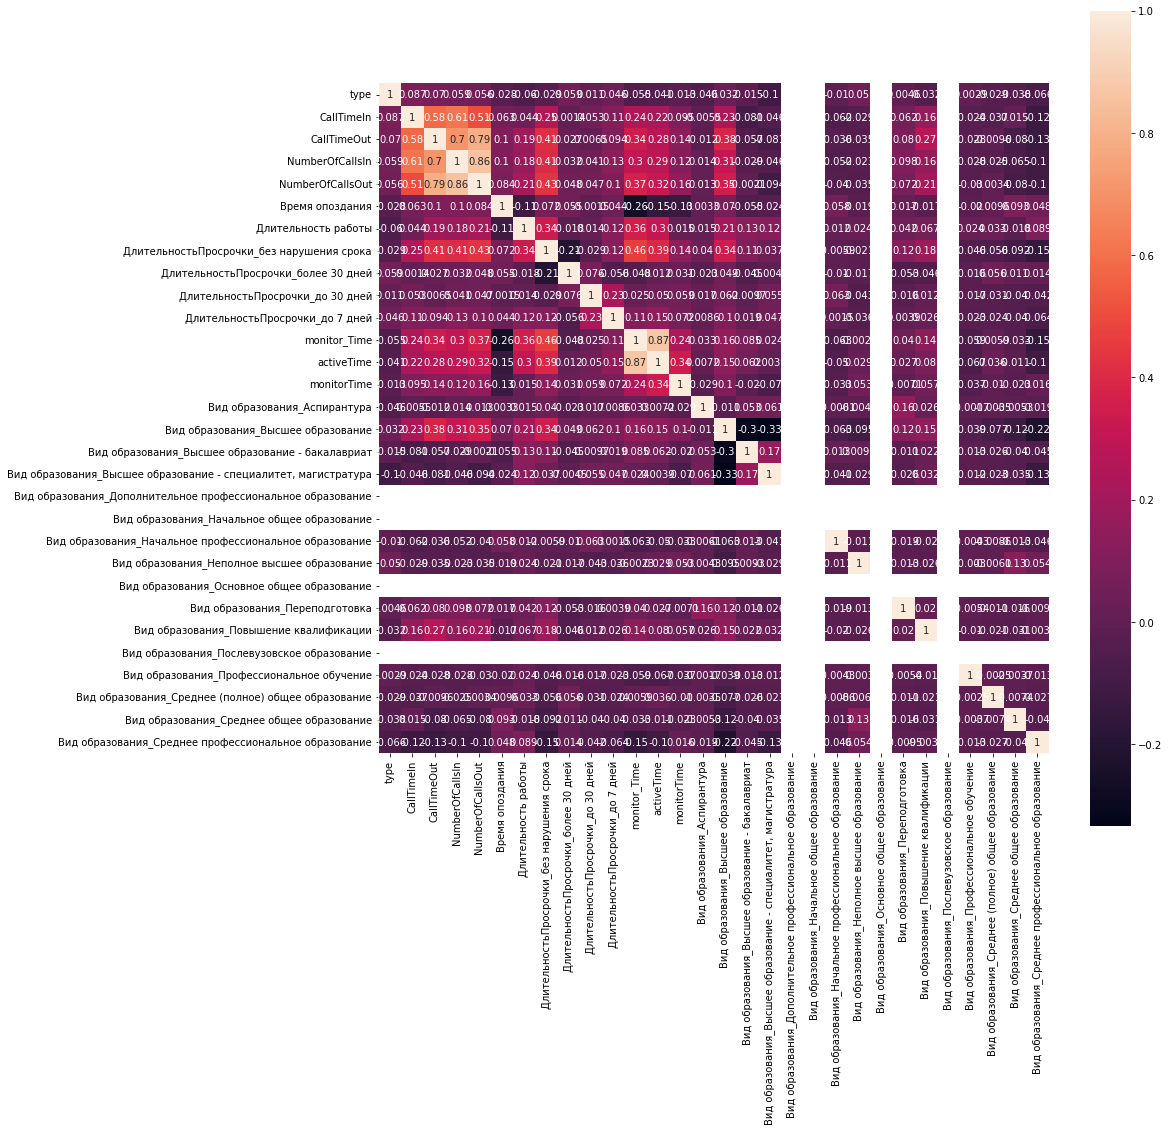

In [85]:
plt.rcParams['figure.figsize']=(15,15)

corr = df.corr()
g = sns.heatmap(corr, square = True, annot=True)

### Пожалуй, колонку monitorTime нужно убрать, из-за тесной корреляции с monitor_Time

In [86]:
df = df.drop(['monitorTime'],axis = 1)

## Выделим выборки

In [93]:
#df = df.set_index('id')
df

,type,Тип,CallTimeIn,CallTimeOut,NumberOfCallsIn,NumberOfCallsOut,Время опоздания,Длительность работы,ДлительностьПросрочки_без нарушения срока,ДлительностьПросрочки_более 30 дней,...,Вид образования_Начальное профессиональное образование,Вид образования_Неполное высшее образование,Вид образования_Основное общее образование,Вид образования_Переподготовка,Вид образования_Повышение квалификации,Вид образования_Послевузовское образование,Вид образования_Профессиональное обучение,Вид образования_Среднее (полное) общее образование,Вид образования_Среднее общее образование,Вид образования_Среднее профессиональное образование
id,,,,,,,,,,,,,,,,,,,,,
ОРГ1-02050,2,train,0.247385,0.109659,4.933333,2.346667,0.152367,9.078743,1.000000,0.000000,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ОРГ1-02783,2,train,0.127034,0.115688,6.552632,2.946188,0.330363,9.016001,0.836601,0.022876,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ОРГ2-06173,0,train,0.000000,0.000000,0.000000,0.000000,0.545419,8.329143,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ОРГ2-05359,2,train,0.000000,0.000000,0.000000,0.000000,0.214652,8.245604,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
ОРГ1-00803,2,train,0.006944,0.032500,3.000000,1.000000,4.043615,2.486520,0.881250,0.025000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ОРГ1-02893,0,test,0.080016,0.115496,3.285714,3.820961,2.640446,5.919239,1.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
ОРГ2-01077,0,test,0.000000,0.000000,0.000000,0.000000,0.406732,7.869449,0.250000,0.500000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ОРГ1-00469,0,test,0.205891,0.139136,8.651408,5.334677,0.084342,10.074700,0.647059,0.071429,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [97]:
X = df.drop(['type'],axis=1)
y = df[['type', 'Тип']]

In [98]:
X

,Тип,CallTimeIn,CallTimeOut,NumberOfCallsIn,NumberOfCallsOut,Время опоздания,Длительность работы,ДлительностьПросрочки_без нарушения срока,ДлительностьПросрочки_более 30 дней,ДлительностьПросрочки_до 30 дней,...,Вид образования_Начальное профессиональное образование,Вид образования_Неполное высшее образование,Вид образования_Основное общее образование,Вид образования_Переподготовка,Вид образования_Повышение квалификации,Вид образования_Послевузовское образование,Вид образования_Профессиональное обучение,Вид образования_Среднее (полное) общее образование,Вид образования_Среднее общее образование,Вид образования_Среднее профессиональное образование
id,,,,,,,,,,,,,,,,,,,,,
ОРГ1-02050,train,0.247385,0.109659,4.933333,2.346667,0.152367,9.078743,1.000000,0.000000,0.000000,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ОРГ1-02783,train,0.127034,0.115688,6.552632,2.946188,0.330363,9.016001,0.836601,0.022876,0.081699,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ОРГ2-06173,train,0.000000,0.000000,0.000000,0.000000,0.545419,8.329143,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ОРГ2-05359,train,0.000000,0.000000,0.000000,0.000000,0.214652,8.245604,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
ОРГ1-00803,train,0.006944,0.032500,3.000000,1.000000,4.043615,2.486520,0.881250,0.025000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ОРГ1-02893,test,0.080016,0.115496,3.285714,3.820961,2.640446,5.919239,1.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
ОРГ2-01077,test,0.000000,0.000000,0.000000,0.000000,0.406732,7.869449,0.250000,0.500000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ОРГ1-00469,test,0.205891,0.139136,8.651408,5.334677,0.084342,10.074700,0.647059,0.071429,0.113445,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [99]:
y

,type,Тип
id,,
ОРГ1-02050,2,train
ОРГ1-02783,2,train
ОРГ2-06173,0,train
ОРГ2-05359,2,train
ОРГ1-00803,2,train
...,...,...
ОРГ1-02893,0,test
ОРГ2-01077,0,test
ОРГ1-00469,0,test


In [100]:
X_train = X[X['Тип']=='train']
X_train = X_train.drop(['Тип'],axis=1)
y_train = y[y['Тип']=='train']
y_train = y_train.drop(['Тип'],axis=1)

In [101]:
X_train

,CallTimeIn,CallTimeOut,NumberOfCallsIn,NumberOfCallsOut,Время опоздания,Длительность работы,ДлительностьПросрочки_без нарушения срока,ДлительностьПросрочки_более 30 дней,ДлительностьПросрочки_до 30 дней,ДлительностьПросрочки_до 7 дней,...,Вид образования_Начальное профессиональное образование,Вид образования_Неполное высшее образование,Вид образования_Основное общее образование,Вид образования_Переподготовка,Вид образования_Повышение квалификации,Вид образования_Послевузовское образование,Вид образования_Профессиональное обучение,Вид образования_Среднее (полное) общее образование,Вид образования_Среднее общее образование,Вид образования_Среднее профессиональное образование
id,,,,,,,,,,,,,,,,,,,,,
ОРГ1-02050,0.247385,0.109659,4.933333,2.346667,0.152367,9.078743,1.000000,0.000000,0.000000,0.000000,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ОРГ1-02783,0.127034,0.115688,6.552632,2.946188,0.330363,9.016001,0.836601,0.022876,0.081699,0.058824,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ОРГ2-06173,0.000000,0.000000,0.000000,0.000000,0.545419,8.329143,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ОРГ2-05359,0.000000,0.000000,0.000000,0.000000,0.214652,8.245604,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
ОРГ1-00803,0.006944,0.032500,3.000000,1.000000,4.043615,2.486520,0.881250,0.025000,0.000000,0.093750,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ОРГ1-02587,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.669065,0.143885,0.093525,0.093525,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ОРГ1-02383,0.366622,0.207349,8.801223,4.904348,2.319171,6.715405,0.190476,0.628571,0.104762,0.076190,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ОРГ1-02862,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [102]:
y_train

,type
id,
ОРГ1-02050,2
ОРГ1-02783,2
ОРГ2-06173,0
ОРГ2-05359,2
ОРГ1-00803,2
...,...
ОРГ1-02587,2
ОРГ1-02383,2
ОРГ1-02862,2


## Обучение модели

In [105]:
clf = RandomForestClassifier(random_state=42)

In [106]:
clf.fit(X_train, y_train.values.ravel())

RandomForestClassifier(random_state=42)

## Получение предсказаний

In [128]:
X_test = X[X['Тип']=='test']
X_test = X_test.drop(['Тип'],axis=1)
y_test = y[y['Тип']=='test']
y_test = y_test.drop(['Тип'],axis=1)

In [129]:
X_test

,CallTimeIn,CallTimeOut,NumberOfCallsIn,NumberOfCallsOut,Время опоздания,Длительность работы,ДлительностьПросрочки_без нарушения срока,ДлительностьПросрочки_более 30 дней,ДлительностьПросрочки_до 30 дней,ДлительностьПросрочки_до 7 дней,...,Вид образования_Начальное профессиональное образование,Вид образования_Неполное высшее образование,Вид образования_Основное общее образование,Вид образования_Переподготовка,Вид образования_Повышение квалификации,Вид образования_Послевузовское образование,Вид образования_Профессиональное обучение,Вид образования_Среднее (полное) общее образование,Вид образования_Среднее общее образование,Вид образования_Среднее профессиональное образование
id,,,,,,,,,,,,,,,,,,,,,
ОРГ1-02649,0.036759,0.000000,1.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ОРГ2-05929,0.000000,0.000000,0.000000,0.000000,0.934041,6.459683,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ОРГ2-05859,0.000000,0.000000,0.000000,0.000000,0.686328,8.043959,0.050000,0.950000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
ОРГ1-00279,0.652210,0.174474,13.670732,4.777922,0.392657,9.575232,0.947776,0.001934,0.015474,0.034816,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
ОРГ2-01613,0.000000,0.000000,0.000000,0.000000,0.162034,8.776184,0.666667,0.111111,0.222222,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ОРГ1-02893,0.080016,0.115496,3.285714,3.820961,2.640446,5.919239,1.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
ОРГ2-01077,0.000000,0.000000,0.000000,0.000000,0.406732,7.869449,0.250000,0.500000,0.000000,0.250000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ОРГ1-00469,0.205891,0.139136,8.651408,5.334677,0.084342,10.074700,0.647059,0.071429,0.113445,0.168067,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [131]:
y_test

,type
id,
ОРГ1-02649,0
ОРГ2-05929,0
ОРГ2-05859,0
ОРГ1-00279,0
ОРГ2-01613,0
...,...
ОРГ1-02893,0
ОРГ2-01077,0
ОРГ1-00469,0


In [132]:
y_pred = clf.predict(X_test)

In [133]:
y_pred

array([2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2,
       2, 0, 0, 2, 2, 2, 2, 0, 2, 0, 2, 2, 2, 2, 0, 2, 1, 2, 2, 2, 2, 2,
       2, 2, 0, 2, 2, 2, 0, 0, 2, 2, 0, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 1, 2, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 0, 2, 2,
       2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 0, 2, 2, 0,
       0, 2, 2, 2, 1, 2, 2, 2, 1, 2, 0, 0, 2, 0, 0, 2, 2, 0, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2,
       0, 0, 2, 2, 2, 1, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2,
       0, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 2, 2, 0,
       2, 2, 0, 0, 0, 2, 0, 2, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 1, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 0, 2, 2, 0, 2, 0, 2, 2, 2, 1],
      dtype=int64)

In [134]:
y_test['type'] = y_pred

In [135]:
y_test

,type
id,
ОРГ1-02649,2
ОРГ2-05929,2
ОРГ2-05859,2
ОРГ1-00279,2
ОРГ2-01613,2
...,...
ОРГ1-02893,0
ОРГ2-01077,2
ОРГ1-00469,2


In [136]:
y_test = y_test.reset_index()

In [137]:
y_test

,id,type
0,ОРГ1-02649,2
1,ОРГ2-05929,2
2,ОРГ2-05859,2
3,ОРГ1-00279,2
4,ОРГ2-01613,2
...,...,...
257,ОРГ1-02893,0
258,ОРГ2-01077,2
259,ОРГ1-00469,2
260,ОРГ1-02060,2


In [138]:
y_test.to_csv("./content/RSF_solution.csv", index=False)